# Heurísticas Construtivas aplicadas ao TSP

**Desenvolvedor**: Vítor Gabriel Reis Caitité 

In [115]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
import time 
from random import choice
import time

## Função para cálculo da matrix de distâncias

In [271]:
# Cálculo da matrix de distâncias considerando a distância euclideana
def calculate_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            d[l, c] = sqrt(sum((data[l] - data[c])**2))
    return d

### Exemplo de matrix de distâncias para um problema

In [270]:
path = '~/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/Vrp-Set-A/A/' 
df = pd.read_csv(f'{path}A-n32-k5.vrp', skiprows=range(0, 4), sep='\s+', names=["i","X", "Y"]) 
if df["Y"].iloc[0] == "EUC_2D":
    df = df[:-4]
    truck_capacity = df["Y"].iloc[1]
    df1 = df[(df.index[df.i == 'DEMAND_SECTION'][0] + 1):df.shape[0]]
    demand = df1['X'].to_numpy(dtype=int)
    coord = df[3:(df.index[df.i == 'DEMAND_SECTION'][0])][["X", "Y"]].to_numpy(dtype=int)

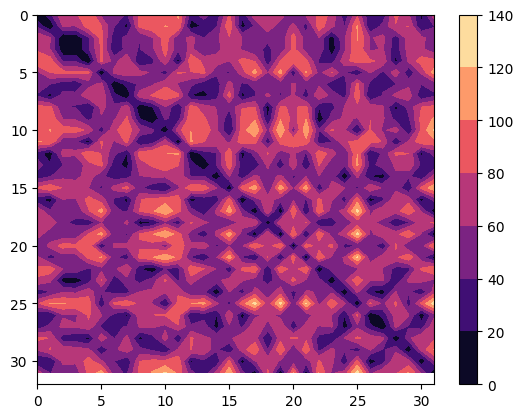

In [136]:
d = calculate_euc_distance_matrix(coord)
plt.contourf(d, cmap='magma')
plt.ylim([d.shape[0], 0])
plt.colorbar()

## Nearest Neighbor

In [262]:
# Nearest neighbor for TSP:
def nearest_neighbor(distance_matrix, demand, truck_capacity, depot = 0):
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    # The truck starts at the depot:
    path = [depot]    # variable to save the path
    unvisited[depot] = 0 
    cost = 0
    while np.sum(unvisited)>0:
        # First place to visit: 
        possible_starts = np.arange(0, distance_matrix.shape[0])
        start = choice(possible_starts[unvisited])
        path.append(start)  
        unvisited[start] = 0
        cost += distance_matrix[depot, path[-1]] 
        capacity = truck_capacity - demand[start]
        while capacity > 0 and np.sum(unvisited)>0:
            last_city = path[-1]
            # finding the nearest neighbor for the last city:
            next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
            next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
            # adding the nearest neighbor to the path if the capacity allows:
            if capacity >= demand[next_city]:
                path.append(next_city)
                unvisited[next_city] = 0
                capacity -= demand[next_city]
                # Updating the cost:
                cost += distance_matrix[last_city, next_city]
                if np.sum(unvisited)==0:
                    cost += distance_matrix[path[-1], path[0]]
                    path.append(depot)
                    break
            else:
                # restore the capacity:
                capacity = truck_capacity
                # add cost to return to depot:
                cost += distance_matrix[path[-1], path[0]]
                path.append(depot)
                break
    return path, cost

## Função para aplicação dos testes

In [263]:
def apply_test(arquives, n_tests):
    final_results = [["Arquivo", 'Nearest Neighbor']]
    final_time_results = [["Arquivo", 'Nearest Neighbor']]
    path = '/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/to_test/'
    for arquive in arquives:
        df = pd.read_csv(f'{path}{arquive}', skiprows=range(0, 4), sep='\s+', names=["i","X", "Y"]) 
        if df["Y"].iloc[0] == "EUC_2D":
            df = df[:-4]
            truck_capacity = df["Y"].iloc[1]
            df1 = df[(df.index[df.i == 'DEMAND_SECTION'][0] + 1):df.shape[0]]
            demand = df1['X'].to_numpy(dtype=float)
            coord = df[3:(df.index[df.i == 'DEMAND_SECTION'][0])][["X", "Y"]].to_numpy(dtype=float)
        else:
            continue       
        distance_matrix = calculate_euc_distance_matrix(coord)
        nn_results = np.zeros(n_tests) # for nearest neighbor
        nn_time_results = np.zeros(n_tests) # for nearest neighbor
        for idx in range(n_tests):
            start_time = time.time()
            _, nn_results[idx] = nearest_neighbor(distance_matrix, demand, truck_capacity=100, depot=0)
            end_time = time.time()
            nn_time_results[idx] = (end_time - start_time)*1000
        result = [arquive,
                 '{:.0f}'.format(nn_results.mean()) + " +/- " + '{:.0f}'.format(nn_results.std())]
        
        time_result = [arquive,
                 '{:.1f}'.format(nn_time_results.mean()) + " +/- " + '{:.1f}'.format(nn_time_results.std())]    
        final_results.append(result)
        final_time_results.append(time_result)
    return final_results, final_time_results

## Resultados

In [267]:
import os
import re
import tabulate
arquives = []
path = '/home/vitor/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/TP_Final _Article_VRPC/instances/to_test'
for root, dirs, files in os.walk(path):
    for filename in sorted(files):
        if re.search(r'.vrp', filename):
            arquives.append(filename)
results, time_results = apply_test(arquives, 10)
# Generating table results:
table1 = tabulate.tabulate(results, tablefmt='grid')
table2 = tabulate.tabulate(time_results, tablefmt='grid')

### Custo obtido por cada algoritmo em cada arquivo de teste.

In [268]:
print(table1)

+-----------------+------------------+
| Arquivo         | Nearest Neighbor |
+-----------------+------------------+
| A-n32-k5.vrp    | 1012 +/- 61      |
+-----------------+------------------+
| A-n33-k5.vrp    | 815 +/- 32       |
+-----------------+------------------+
| A-n34-k5.vrp    | 949 +/- 37       |
+-----------------+------------------+
| A-n36-k5.vrp    | 1030 +/- 42      |
+-----------------+------------------+
| A-n37-k5.vrp    | 885 +/- 58       |
+-----------------+------------------+
| A-n37-k6.vrp    | 1146 +/- 51      |
+-----------------+------------------+
| A-n38-k5.vrp    | 893 +/- 69       |
+-----------------+------------------+
| A-n39-k5.vrp    | 1052 +/- 64      |
+-----------------+------------------+
| A-n39-k6.vrp    | 1011 +/- 65      |
+-----------------+------------------+
| A-n44-k6.vrp    | 1241 +/- 92      |
+-----------------+------------------+
| A-n45-k6.vrp    | 1144 +/- 88      |
+-----------------+------------------+
| A-n45-k7.vrp    | 1352 

### Tempo de execução (ms) de cada algoritmo em cada arquivo de teste. Processador i7 7th Gen., 8 Gb de RAM, sistema Linux.

In [269]:
print(table2)

+-----------------+------------------+
| Arquivo         | Nearest Neighbor |
+-----------------+------------------+
| A-n32-k5.vrp    | 0.8 +/- 0.2      |
+-----------------+------------------+
| A-n33-k5.vrp    | 0.7 +/- 0.2      |
+-----------------+------------------+
| A-n34-k5.vrp    | 0.8 +/- 0.3      |
+-----------------+------------------+
| A-n36-k5.vrp    | 0.8 +/- 0.4      |
+-----------------+------------------+
| A-n37-k5.vrp    | 0.6 +/- 0.3      |
+-----------------+------------------+
| A-n37-k6.vrp    | 0.5 +/- 0.0      |
+-----------------+------------------+
| A-n38-k5.vrp    | 0.5 +/- 0.1      |
+-----------------+------------------+
| A-n39-k5.vrp    | 0.5 +/- 0.0      |
+-----------------+------------------+
| A-n39-k6.vrp    | 0.5 +/- 0.0      |
+-----------------+------------------+
| A-n44-k6.vrp    | 0.7 +/- 0.2      |
+-----------------+------------------+
| A-n45-k6.vrp    | 0.8 +/- 0.2      |
+-----------------+------------------+
| A-n45-k7.vrp    | 0.7 +